In [1]:
from collections import deque

import gym
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical 

In [2]:
class ActorCriticNet(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()
        h = 64
        self.head = nn.Sequential(
            nn.Linear(obs_space, h),
            nn.Tanh()
        )
        self.pol = nn.Sequential(
            nn.Linear(h, h),
            nn.Tanh(),
            nn.Linear(h, action_space)
        )
        self.val = nn.Sequential(
            nn.Linear(h, h),
            nn.Tanh(),
            nn.Linear(h, 1)
        )
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        out = self.head(x)
        logit = self.pol(out).reshape(out.shape[0], -1)
        log_p = self.log_softmax(logit)
        v = self.val(out).reshape(out.shape[0], 1)

        return log_p, v

In [3]:
def get_action_and_value(obs, old_net):
    old_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p, v = old_net(state)
        m = Categorical(log_p.exp())
        action = m.sample()

    return action.item(), v.item()

## Main

In [4]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# make an environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

SEED = 0
env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
n_eval = env.spec.trials

# global values
total_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_solved = False

# load a model
target_net = ActorCriticNet(obs_space, action_space).to(device)
target_net.load_state_dict(torch.load(
    './saved_models/CartPole-v1_ep1163_clear_model_ppo_st.pt'))

/home/jay/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [5]:
env.spec.max_episode_steps

500

In [6]:
env.spec.trials

100

In [7]:
env.spec.reward_threshold

475.0

In [8]:
# env.metadata['video.frames_per_second'] = 60

In [9]:
# play
# frames = []
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         frames.append(env.render(mode = 'rgb_array'))
        env.render()
        action, _ = get_action_and_value(obs, target_net)
        _obs, reward, done, _ = env.step(action)
        obs = _obs
        total_steps += 1
        ep_reward += reward     
    if done:
        env.render()
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))
#         frames.append(env.render(mode = 'rgb_array'))
#         imageio.mimsave(f'{env.spec.id}.gif', frames,)
        
        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                print(np.mean(reward_eval))
                break
env.close()

  1 Episode in   500 steps, reward 500.00
  2 Episode in  1000 steps, reward 500.00
  3 Episode in  1500 steps, reward 500.00
  4 Episode in  2000 steps, reward 500.00
  5 Episode in  2500 steps, reward 500.00
  6 Episode in  3000 steps, reward 500.00
  7 Episode in  3500 steps, reward 500.00
  8 Episode in  4000 steps, reward 500.00
  9 Episode in  4500 steps, reward 500.00
 10 Episode in  5000 steps, reward 500.00
 11 Episode in  5500 steps, reward 500.00
 12 Episode in  6000 steps, reward 500.00
 13 Episode in  6500 steps, reward 500.00
 14 Episode in  7000 steps, reward 500.00
 15 Episode in  7500 steps, reward 500.00
 16 Episode in  8000 steps, reward 500.00
 17 Episode in  8500 steps, reward 500.00
 18 Episode in  9000 steps, reward 500.00
 19 Episode in  9500 steps, reward 500.00
 20 Episode in 10000 steps, reward 500.00
 21 Episode in 10500 steps, reward 500.00
 22 Episode in 11000 steps, reward 500.00
 23 Episode in 11500 steps, reward 500.00
 24 Episode in 12000 steps, reward

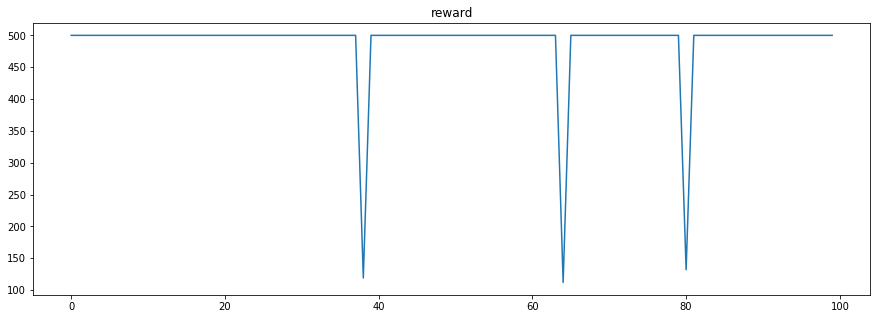

In [10]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.show()

In [11]:
[
    ('CartPole-v0', 412, 1),
    ('CartPole-v1', 452, 0.05),
    ('MountainCar-v0', 193, 0.1),
    ('LunarLander-v2', 260, 0.1)
]

[('CartPole-v0', 412, 1),
 ('CartPole-v1', 452, 0.05),
 ('MountainCar-v0', 193, 0.1),
 ('LunarLander-v2', 260, 0.1)]